# Window Functions

Spark also supports window functions for aggregations. Window functions allow more complex aggregations like sliding windows or ranking, where for each row a set of 'surrounding' rows are used for calculating an additional metric.

In this example, we will use the weather data and add a sliding average temparature to the existing columns. The result DataFrame shall have both metrics: The actual temperature (as stored in the original records) and an averaged value.

In [1]:
import pandas as pd

import pyspark.sql.functions as f

from pyspark.sql.types import *
from pyspark.sql import SparkSession

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","24G") \
        .getOrCreate()

spark

/opt/anaconda3/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 18:18:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1 General Preparations

First we enable Matplot inline graphics and set the base location of all data

In [2]:
%matplotlib inline

In [7]:
storageLocation = "s3://dimajix-training/data/weather"

# 2 Loading Data

Again we load data for the single year 2003 from S3 (or whatever storage location is used)

In [6]:
rawWeatherData = spark.read.text(storageLocation + "/2003")
weatherData = rawWeatherData.select(
    f.substring(f.col("value"),5,6).alias("usaf"),
    f.substring(f.col("value"),11,5).alias("wban"),
    f.date_format(f.to_timestamp(f.substring(f.col("value"),16,12),"yyyyMMddHHmm"), "yyyy-MM-dd HH:mm:ss").alias("timestamp"),
    f.to_timestamp(f.substring(f.col("value"),16,12),"yyyyMMddHHmm").cast("long").alias("ts"),
    f.substring(f.col("value"),42,5).alias("report_type"),
    f.substring(f.col("value"),61,3).alias("wind_direction"),
    f.substring(f.col("value"),64,1).alias("wind_direction_qual"),
    f.substring(f.col("value"),65,1).alias("wind_observation"),
    (f.substring(f.col("value"),66,4).cast("float") / f.lit(10.0)).alias("wind_speed"),
    f.substring(f.col("value"),70,1).alias("wind_speed_qual"),
    (f.substring(f.col("value"),88,5).cast("float") / f.lit(10.0)).alias("air_temperature"),
    f.substring(f.col("value"),93,1).alias("air_temperature_qual")
)

In [7]:
# Replace invalid values with NULL values
weatherData = weatherData \
    .withColumn('air_temperature', f.when(weatherData['air_temperature_qual'] == 1, weatherData['air_temperature'])) \
    .withColumn('wind_speed', f.when(weatherData['wind_speed_qual'] == 1, weatherData['wind_speed']))

In [8]:
# Make the weather data available as a temporary view
weather_all = weatherData.cache()
weather_all.createOrReplaceTempView("weather_all")

In [9]:
# Peek inside the data, just to make sure everything looks right
spark.sql("""
    SELECT * FROM weather_all LIMIT 10
""").toPandas()

,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual
0,703160,25624,2003-01-01 00:00:00,1041379200,SY-MT,010,5,N,NaN,5,NaN,5
1,703160,25624,2003-01-01 00:17:00,1041380220,FM-16,020,1,N,4.6,1,-2.0,1
2,703160,25624,2003-01-01 00:53:00,1041382380,FM-15,010,5,N,NaN,5,NaN,5
3,703160,25624,2003-01-01 01:00:00,1041382800,NSRDB,999,9,9,NaN,9,NaN,9
4,703160,25624,2003-01-01 01:53:00,1041385980,FM-15,010,5,N,NaN,5,NaN,5
5,703160,25624,2003-01-01 02:00:00,1041386400,NSRDB,999,9,9,NaN,9,NaN,9
6,703160,25624,2003-01-01 02:53:00,1041389580,FM-15,010,5,N,NaN,5,NaN,5
7,703160,25624,2003-01-01 03:00:00,1041390000,NSRDB,999,9,9,NaN,9,NaN,9
8,703160,25624,2003-01-01 03:53:00,1041393180,FM-15,020,5,N,NaN,5,NaN,5
9,703160,25624,2003-01-01 04:00:00,1041393600,NSRDB,999,9,9,NaN,9,NaN,9


# 3 Pick a single station

For our first steps, we limit ourselves to a single weather station. We pick one with `usaf='954920'` and `wban='99999'`. This is enough to demonstrate the basic functions of window functions for a sliding average.

In [10]:
weather_single = weatherData.where("usaf='954920' and wban='99999'").cache()
weather_single.createOrReplaceTempView("weather_single")

In [11]:
spark.sql("""
    SELECT * FROM weather_single LIMIT 10
""").toPandas()

,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual
0,954920,99999,2003-01-01 00:00:00,1041379200,FM-12,200,1,N,4.6,1,25.6,1
1,954920,99999,2003-01-01 02:00:00,1041386400,FM-12,230,1,N,5.7,1,27.8,1
2,954920,99999,2003-01-01 03:00:00,1041390000,FM-12,220,1,N,7.7,1,29.6,1
3,954920,99999,2003-01-01 05:00:00,1041397200,FM-12,230,1,N,6.2,1,29.7,1
4,954920,99999,2003-01-01 06:00:00,1041400800,FM-12,240,1,N,6.7,1,30.2,1
5,954920,99999,2003-01-01 08:00:00,1041408000,FM-12,210,1,N,6.7,1,29.1,1
6,954920,99999,2003-01-01 09:00:00,1041411600,FM-12,220,1,N,5.7,1,28.0,1
7,954920,99999,2003-01-01 11:00:00,1041418800,FM-12,210,1,N,3.6,1,25.9,1
8,954920,99999,2003-01-01 12:00:00,1041422400,FM-12,200,1,N,4.1,1,25.0,1
9,954920,99999,2003-01-01 14:00:00,1041429600,FM-12,190,1,N,6.2,1,23.0,1


# 4 Sliding Average

Now we want to calculate the sliding average of the temperature as an additional metric. First we use SQL for that task, later we will see how to use the DataFrame API for performing the same task.

In order to perform a windowed aggregation, you use the following syntax to specify a column expression:
```
    AGGREGATE_FUNCTION(columns) OVER(window_specification)
```
The term `window_specification` is constructed from the following components:
```
    PARTITION BY category
    ORDER BY ordering_column [ASC|DESC]
    RANGE BETWEEN start PRECEEDING AND end FOLLOWING
```

* `PARTITION BY` works similar to a `GROUP BY` operation. It controls which rows will be in the same partition with the given row. Also, the user might want to make sure all rows having the same value for  the category column are collected to the same machine before ordering and calculating the frame.  If no partitioning specification is given, then all data must be collected to a single machine. - it filters records which are used for creating each window
* `ORDER BY` sorts all records of a single window accordingly. It controls the way that rows in a partition are ordered, determining the position of the given row in its partition.
* `RANGE BETWEEN` states which rows will be included in the frame for the current input row, based on their relative position to the current row.  For example, “the three rows preceding the current row to the current row” describes a frame including the current input row and three rows appearing before the current row.

### Frame Types

As an alternative to `RANGE BETWEEN` there is also `ROWS BETWEEN`. While `RANGE BETWEEN` refers to the values of the sorting column, `ROWS BETWEEN` simply counts the number of rows. Both window types have their use: `RANGE BETWEEN` is perfect for sliding averages over time windows of constant duration, while `ROWS BETWEEN` is useful for ordered entries lacking a proper arithmetic scale.

### Boundaries 
Both frame types (range and rows) support different boundary types:
* `UNBOUNDED PRECEDING`
* `UNBOUNDED FOLLOWING`
* `CURRENT ROW`
* `<value> PRECEDING`
* `<value> FOLLOWING`

## 4.1 Sliding average calculation

In [12]:
result = spark.sql("""
    SELECT
        *,
        air_temperature AS temp,
        AVG(air_temperature) 
            OVER (ORDER BY ts ASC RANGE BETWEEN 36000 PRECEDING AND 36000 FOLLOWING) AS avg_temp
    FROM
        weather_single
    ORDER BY ts
""")

result.limit(10).toPandas()

23/11/08 18:20:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,temp,avg_temp
0,954920,99999,2003-01-01 00:00:00,1041379200,FM-12,200,1,N,4.6,1,25.6,1,25.6,28.571429
1,954920,99999,2003-01-01 02:00:00,1041386400,FM-12,230,1,N,5.7,1,27.8,1,27.8,27.877778
2,954920,99999,2003-01-01 03:00:00,1041390000,FM-12,220,1,N,7.7,1,29.6,1,29.6,27.877778
3,954920,99999,2003-01-01 05:00:00,1041397200,FM-12,230,1,N,6.2,1,29.7,1,29.7,26.890909
4,954920,99999,2003-01-01 06:00:00,1041400800,FM-12,240,1,N,6.7,1,30.2,1,30.2,26.890909
5,954920,99999,2003-01-01 08:00:00,1041408000,FM-12,210,1,N,6.7,1,29.1,1,29.1,25.761538
6,954920,99999,2003-01-01 09:00:00,1041411600,FM-12,220,1,N,5.7,1,28.0,1,28.0,25.761538
7,954920,99999,2003-01-01 11:00:00,1041418800,FM-12,210,1,N,3.6,1,25.9,1,25.9,24.892857
8,954920,99999,2003-01-01 12:00:00,1041422400,FM-12,200,1,N,4.1,1,25.0,1,25.0,24.892857
9,954920,99999,2003-01-01 14:00:00,1041429600,FM-12,190,1,N,6.2,1,23.0,1,23.0,24.192857


### Draw a picture

In order to verify our approach, let's draw a picture with Matplotlib, which shows the current temperature and the sliding average in a single plot.

23/11/08 18:20:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Axes: xlabel='timestamp'>

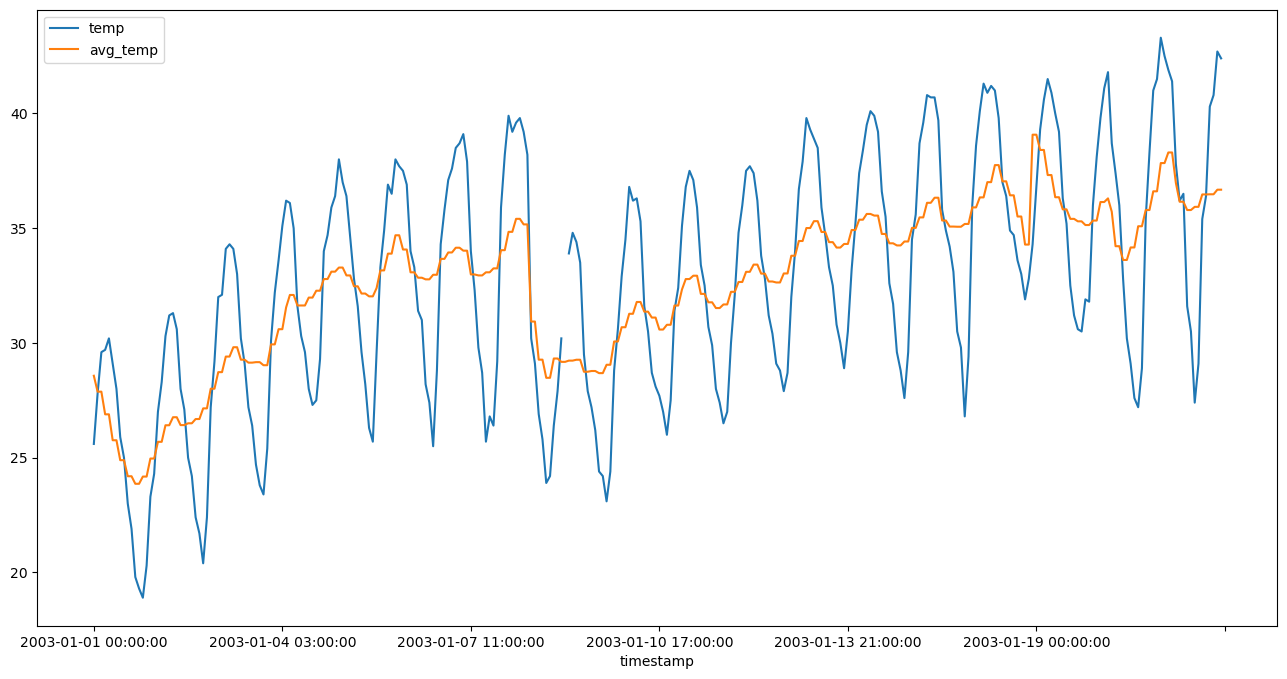

In [13]:
pdf = result.limit(300).toPandas()
pdf.plot(x='timestamp', y=['temp','avg_temp'], figsize=[16,8])

## 4.2 Window Aggregation Functions

We already used simple standard aggregation functions, which are also available without windows. But there are also some special aggregation functions, which were specifically designed to be used with windowed aggregation and cannot be used without a window definition.

These are

Function class | SQL | DataFrame Function | Description
---------------|-----|--------------------|-------------
Ranking functions|rank|ranke|Get rank in window
|dense_rank|denseRank|
|percent_rank|percentRank|
|ntile|ntile|
|row_number|rowNumber|Get row number in window
Analytic functions|cume_dist|cumeDist|
|first_value|first|Pick first value in window
|last_value|last|Pick last value in window
|lag|lag|Pick preceeding value
|lead|lead|Pick following value

## 4.3 Exercise: Comparing to pervious day

Another use case for window functions is to compare todays temperature to yesterday at the same time. This can be achived by using the function `FIRST_VALUE` together with an appropriate window with a range from 86400 (number of seconds of one day) preceeding and the current row.

**Exercise**: Create a DataFrame with the columns `timestamp`, `temp` (current temperature) and `prev_temp` (previous temperature) and plot the first 300 records.

In [14]:
result = spark.sql("""
    SELECT
        *,
        air_temperature AS temp,
        FIRST_VALUE(air_temperature) 
            OVER (ORDER BY ts ASC RANGE BETWEEN 86400 PRECEDING AND CURRENT ROW) AS prev_temp
    FROM
        weather_single
    ORDER BY ts
""")

result.limit(10).toPandas()

23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,temp,prev_temp
0,954920,99999,2003-01-01 00:00:00,1041379200,FM-12,200,1,N,4.6,1,25.6,1,25.6,25.6
1,954920,99999,2003-01-01 02:00:00,1041386400,FM-12,230,1,N,5.7,1,27.8,1,27.8,25.6
2,954920,99999,2003-01-01 03:00:00,1041390000,FM-12,220,1,N,7.7,1,29.6,1,29.6,25.6
3,954920,99999,2003-01-01 05:00:00,1041397200,FM-12,230,1,N,6.2,1,29.7,1,29.7,25.6
4,954920,99999,2003-01-01 06:00:00,1041400800,FM-12,240,1,N,6.7,1,30.2,1,30.2,25.6
5,954920,99999,2003-01-01 08:00:00,1041408000,FM-12,210,1,N,6.7,1,29.1,1,29.1,25.6
6,954920,99999,2003-01-01 09:00:00,1041411600,FM-12,220,1,N,5.7,1,28.0,1,28.0,25.6
7,954920,99999,2003-01-01 11:00:00,1041418800,FM-12,210,1,N,3.6,1,25.9,1,25.9,25.6
8,954920,99999,2003-01-01 12:00:00,1041422400,FM-12,200,1,N,4.1,1,25.0,1,25.0,25.6
9,954920,99999,2003-01-01 14:00:00,1041429600,FM-12,190,1,N,6.2,1,23.0,1,23.0,25.6


### Draw a picture

Again, draw a picture of the result.

23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Axes: xlabel='timestamp'>

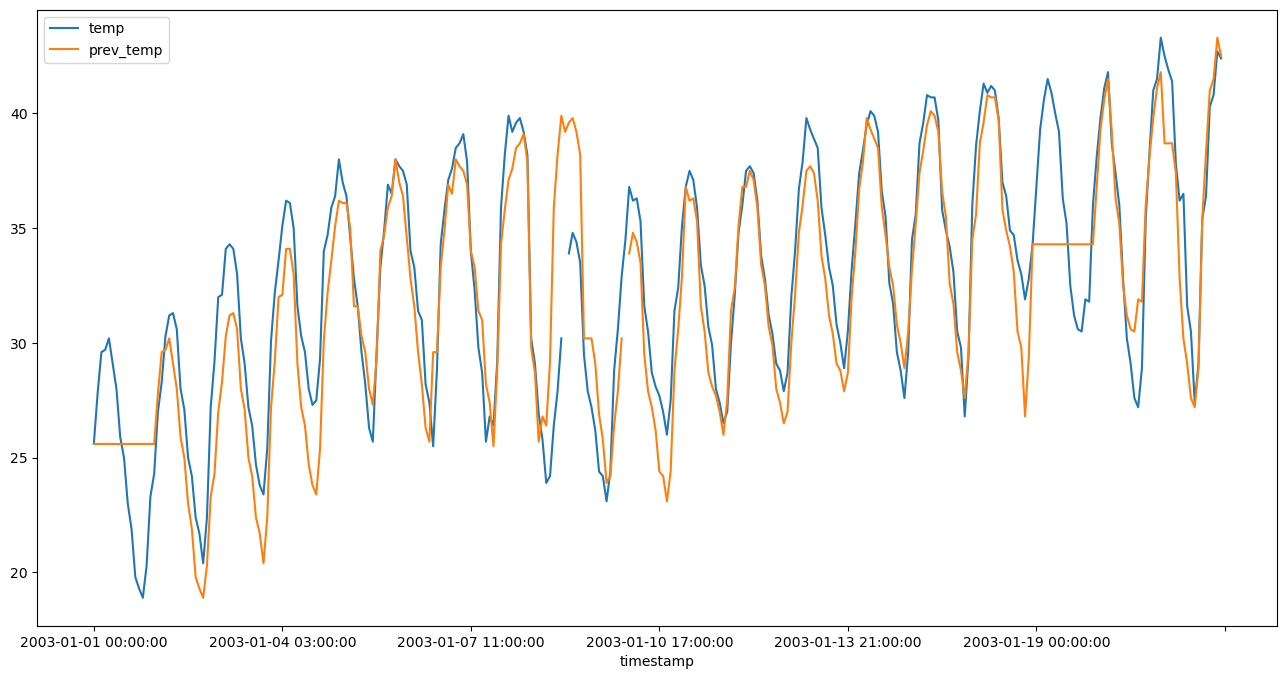

In [15]:
pdf = result.limit(300).toPandas()
pdf.plot(x='timestamp', y=['temp','prev_temp'], figsize=[16,8])

# 5 DataFrame Window API

In addition to the SQL interface, there is also a direct Python interface for creating windowed aggregations. Let us reformulate the initial sliding window average aggregation using the Spark DataFrame API instead of SQL.

## 5.1 Sliding average

In [17]:
from pyspark.sql.window import Window

window_spec = Window \
    .orderBy(weather_single['ts'].asc()) \
    .rangeBetween(-36000, 36000)

result = weather_single.select(
        weather_single["ts"],
        weather_single["timestamp"],
        weather_single["air_temperature"].alias("temp"),
        f.avg(weather_single["air_temperature"]).over(window_spec).alias("avg_temp")
    )\
    .orderBy(weather_single['ts'])

result.limit(10).toPandas()

23/11/08 18:20:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,ts,timestamp,temp,avg_temp
0,1041379200,2003-01-01 00:00:00,25.6,28.571429
1,1041386400,2003-01-01 02:00:00,27.8,27.877778
2,1041390000,2003-01-01 03:00:00,29.6,27.877778
3,1041397200,2003-01-01 05:00:00,29.7,26.890909
4,1041400800,2003-01-01 06:00:00,30.2,26.890909
5,1041408000,2003-01-01 08:00:00,29.1,25.761538
6,1041411600,2003-01-01 09:00:00,28.0,25.761538
7,1041418800,2003-01-01 11:00:00,25.9,24.892857
8,1041422400,2003-01-01 12:00:00,25.0,24.892857
9,1041429600,2003-01-01 14:00:00,23.0,24.192857


### Draw a picture

Using Matplotlib, let's make a picture containing the current temperature and the average temperature in a single plot.

23/11/08 18:20:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:20:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Axes: xlabel='timestamp'>

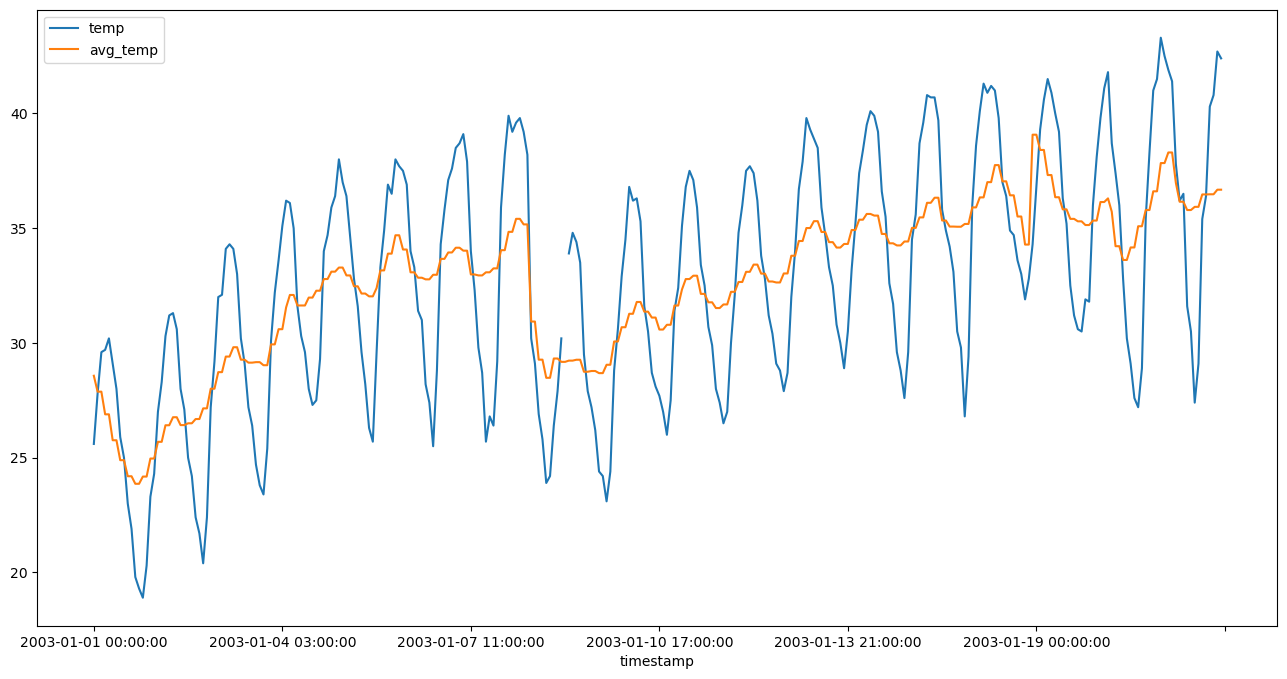

In [18]:
pdf = result.limit(300).toPandas()
pdf.plot(x='timestamp', y=['temp','avg_temp'], figsize=[16,8])

## 5.2 Exercise: Compare temperature to previous day

Now perform the same task as the previous exercise: Make a plot of the current temperature and the one 24h ago using the `first` function. But this time, use the DataFrame API instead of SQL.

In [20]:
from pyspark.sql.window import Window

window_spec = Window \
    .orderBy(weather_single['ts'].asc()) \
    .rangeBetween(-86400, 0)

result = weather_single.select(
        weather_single["ts"],
        weather_single["timestamp"],
        weather_single["air_temperature"].alias("temp"),
        f.first(weather_single["air_temperature"]).over(window_spec).alias("prev_temp")
    )\
    .orderBy(weather_single['ts']) 

result.limit(10).toPandas()

23/11/08 18:21:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,ts,timestamp,temp,prev_temp
0,1041379200,2003-01-01 00:00:00,25.6,25.6
1,1041386400,2003-01-01 02:00:00,27.8,25.6
2,1041390000,2003-01-01 03:00:00,29.6,25.6
3,1041397200,2003-01-01 05:00:00,29.7,25.6
4,1041400800,2003-01-01 06:00:00,30.2,25.6
5,1041408000,2003-01-01 08:00:00,29.1,25.6
6,1041411600,2003-01-01 09:00:00,28.0,25.6
7,1041418800,2003-01-01 11:00:00,25.9,25.6
8,1041422400,2003-01-01 12:00:00,25.0,25.6
9,1041429600,2003-01-01 14:00:00,23.0,25.6


### Draw a picture

In order to verify our approach, let's draw a picture with Matplotlib, which shows the current temperature and the previous temperature in a single plot.

23/11/08 18:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/08 18:21:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Axes: xlabel='timestamp'>

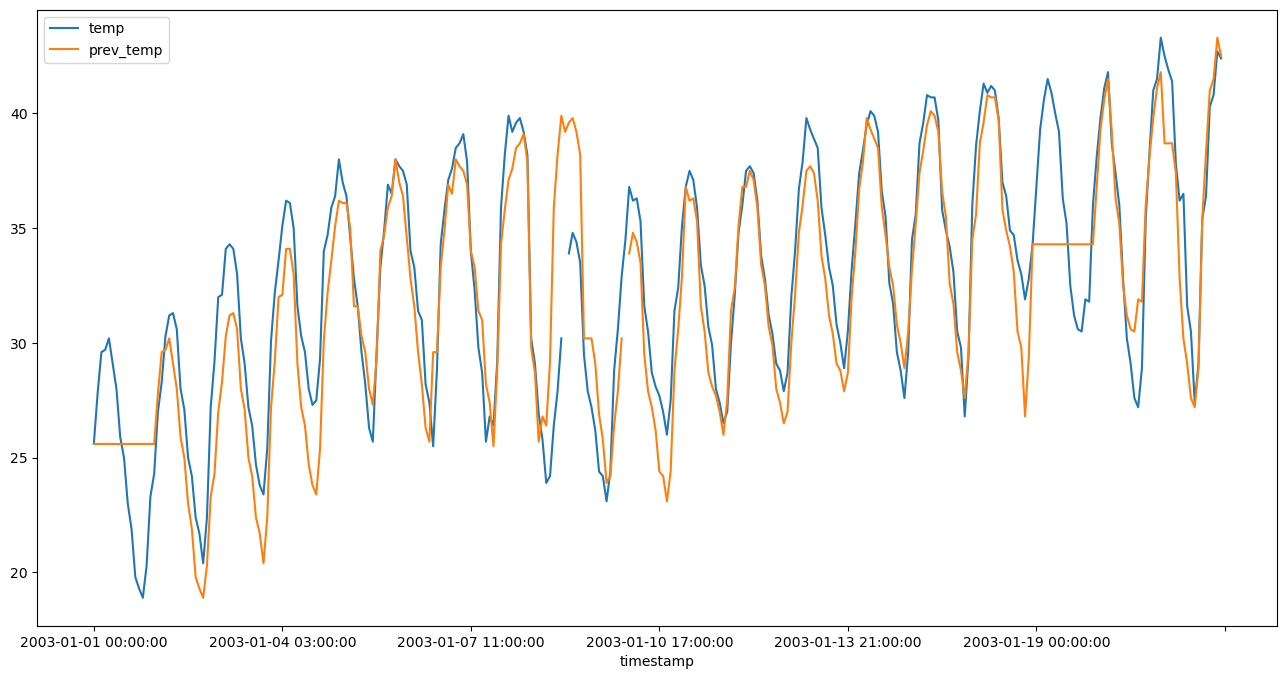

In [21]:
pdf = result.limit(300).toPandas()
pdf.plot(x='timestamp', y=['temp','prev_temp'], figsize=[16,8])

## 5.3 Partitioned Windows

So far we only used windows covering a specific time range. This was good enough, since we were only looking at a single station. But in most cases, you want to perform analyses covering multiple different entitites (different weather stations in this example). In these cases you also need to *partition* the aggregation window, such that only records from the same entity are processed.

Let us calculate the difference of the current temperature to the average of the last day, but this time for all stations at once.

In [24]:
from pyspark.sql.window import Window

window_spec = Window \
    .orderBy(weather_all['ts'].asc()) \
    .partitionBy(weather_all['usaf'], weather_all['wban']) \
    .rangeBetween(-86400, 0)
    
result = weather_all.select(
        weather_all['*'],
        (weather_all['air_temperature'] - f.avg(weather_all['air_temperature']).over(window_spec)).alias("temp_avg_diff")
    )\
    .orderBy(weather_all['ts'])

result.limit(10).toPandas()

,usaf,wban,timestamp,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,temp_avg_diff
0,722530,12921,2003-01-01 00:00:00,1041379200,SY-MT,280,5,N,NaN,5,NaN,5,NaN
1,725744,24027,2003-01-01 00:00:00,1041379200,NSRDB,999,9,9,NaN,9,NaN,9,NaN
2,063400,99999,2003-01-01 00:00:00,1041379200,FM-12,999,9,V,1.0,1,0.5,1,0.0
3,723170,13723,2003-01-01 00:00:00,1041379200,SY-MT,170,5,N,NaN,5,NaN,5,NaN
4,111200,99999,2003-01-01 00:00:00,1041379200,FM-12,999,9,V,1.0,1,4.1,1,0.0
5,999999,04990,2003-01-01 00:00:00,1041379200,CRN05,999,9,R,3.7,1,-0.4,1,0.0
6,034820,99999,2003-01-01 00:00:00,1041379200,FM-12,140,1,N,4.1,1,2.7,1,0.0
7,725760,24021,2003-01-01 00:00:00,1041379200,SY-MT,040,5,N,NaN,5,NaN,5,NaN
8,703884,99999,2003-01-01 00:00:00,1041379200,NSRDB,999,9,9,NaN,9,NaN,9,NaN
9,038940,99999,2003-01-01 00:00:00,1041379200,FM-12,160,1,N,7.2,1,9.6,1,0.0


### Draw a Picture

In order to check the result, we again pick a single station. But this time, we pick it from the final result and not from the input data

<Axes: xlabel='timestamp'>

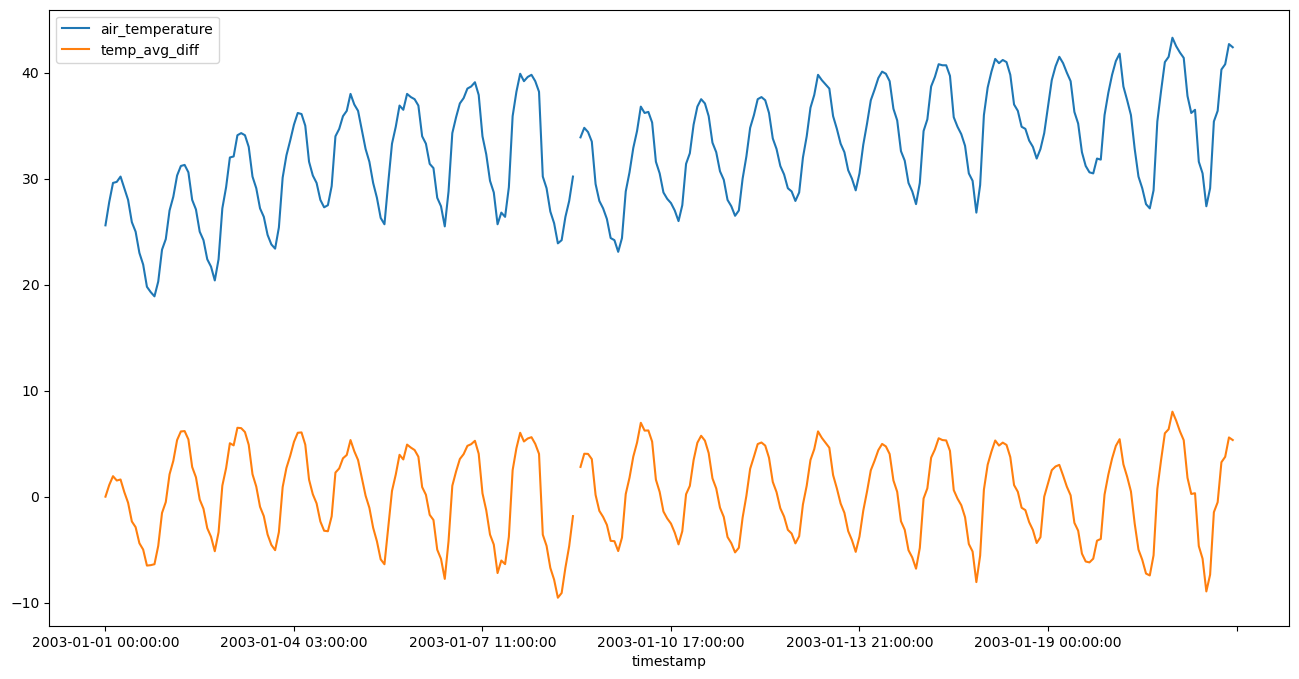

In [25]:
pdf = result.where("usaf='954920' and wban='99999'").limit(300).toPandas()
pdf.plot(x='timestamp', y=['air_temperature','temp_avg_diff'], figsize=[16,8])

## 5.4 Exercise: Min/Max Change Analysis

Now we want to calculate for every weather station:
* The maximum upward difference of temperature within 5 days
* The maximum downward difference of temperature within 5 days

Logically, we want to perform the following steps for every weather station:
1. For every measurement, look back five days
2. Within these five days, find the minimum and maximum temperature
3. Calculate the difference of the current temepature and the minimum and maximum. Store these in `temp_rise` and `temp_fall`
4. Calculate the overall maximum of `temp_rise` and `temp_fall` per station for the whole year

In [29]:
# Calculate the number of seconds for five days
one_day = 24*60*60
five_days = 5*one_day
five_days

432000

In [30]:
# Create a window, which creates a new partition per weather station and looks back 5 days
window_spec = Window \
    .orderBy(weather_all['ts'].asc()) \
    .rangeBetween(-five_days, 0) \
    .partitionBy(weather_all['wban'], weather_all['usaf'])
    
# Calculate the difference for each day from the maximum and minimum temperature of the last five days using the window
# The resulting DataFrame should have the following columns:
#   timestamp
#   usaf
#   wban
#   temp_rise = valid_temp - min(valid_temp).over(window_spec)
#   temp_fall = max(valid_temp).over(window_spec) - valid_temp
weather_rise_fall = weather_all \
    .select(
        weather_all["*"],
        (weather_all['air_temperature'] - f.min(weather_all['air_temperature']).over(window_spec)).alias("temp_rise"),
        (f.max(weather_all['air_temperature']).over(window_spec) - weather_all['air_temperature']).alias("temp_fall")
    )

# Calculate the maximum raise and fall for each station for the whole year. This should be done by a simple grouped aggregation
# The groups are determined by the weather station id, which is given by usaf and wban
result = weather_rise_fall \
    .groupBy(weather_all['usaf'], weather_all['wban']) \
    .agg(
        f.max(weather_rise_fall['temp_rise']).alias("max_temp_rise"),
        f.max(weather_rise_fall['temp_fall']).alias("max_temp_fall")
    )

# Finally show the whole result by converting it to a Pandas DataFrame
result.toPandas()

,usaf,wban,max_temp_rise,max_temp_fall
0,726088,14606,28.0,23.0
1,911900,22516,15.0,14.0
2,727815,24237,15.0,17.0
3,703500,25501,20.0,17.0
4,727680,94008,36.0,35.0
...,...,...,...,...
112,063500,99999,26.4,27.0
113,115180,99999,26.0,28.1
114,270370,99999,32.0,28.5
115,726777,99999,37.0,45.0
